# Predicting LD given LOA and B

In [81]:
# Remove all variables from the environment
%reset -f

# Or, if you want to remove specific variables
# For example, if you have a function named myFunction and a dataframe named myData
# del myFunction, myData

# Clear Console
from IPython.display import clear_output
clear_output()


## Import ship data

In [82]:
# Importing necessary libraries
import pandas as pd

# Uploading ship_data from csv file hosted on GitHub
#Original Source: https://www.mdpi.com/2077-1312/11/5/961
# Table A1. Dimensions and size classes of tankers used in the study.

url = "https://raw.githubusercontent.com/paulo-marquesmorgado/EConcepts/main/ship_data.csv"
ship_data = pd.read_csv(url, sep=";")

# Displaying ship_data
ship_data


,No.,Tanker Group,LOA (m),B (m),LD (t)
0,1,Handy,83.40,13.00,1133.00
1,2,Handy,88.80,14.80,1748.70
2,3,Handy,90.00,15.20,1840.57
3,4,Handy,92.35,15.20,3008.13
4,5,Handy,95.80,15.20,1810.90
...,...,...,...,...,...
75,76,VLCC,333.00,60.00,42749.80
76,77,VLCC,333.00,60.05,44900.00
77,78,VLCC,333.40,56.50,41261.00
78,79,VLCC,336.00,60.00,46974.00


## Create sub dataframes for each ship type

In [83]:
# ship_data is your original DataFrame
# Create a dictionary to store the separate DataFrames
df_dict = {}

# Get unique values in the 'Tanker Group' column
tanker_groups = ship_data['Tanker Group'].unique()

# Loop through each tanker group and create a new DataFrame
for group in tanker_groups:
    # Filter the data for the current group
    subgroup_data = ship_data[ship_data['Tanker Group'] == group].copy()

    # Create a new DataFrame with a dynamic name
    df_name = f"ship_data_{group.replace(' ', '')}"
    df_dict[df_name] = subgroup_data

# Access the created DataFrames using names like ship_data_TankerGroup

# Display DataFrame names in df_dict that start with "ship_data_"
for key in df_dict:
    if key.startswith("ship_data_"):
        print(key)

ship_data_Handy
ship_data_Panamax
ship_data_Aframax
ship_data_Suezmax
ship_data_VLCC


## Calculate the a single xgboost model for all ships and Prdicting LD

In [84]:
# Install and load the xgboost package (if you haven't already):
# !pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data:
# Assuming 'ship_data' is your DataFrame
# Replace 'LOA (m)', 'B (m)', and 'LD (t)' with your actual column names
X = ship_data[['LOA (m)', 'B (m)']].values
y = ship_data['LD (t)'].values

# Split the data into training and testing sets:
np.random.seed(123)  # for reproducibility
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=123)

# Train the XGBoost model:
# Specify the model parameters
params = {
    'objective': 'reg:squarederror',  # for regression
    'eval_metric': 'rmse'  # root mean squared error
}

# Convert the data to DMatrix format
train_dmatrix = xgb.DMatrix(data=train_data, label=train_labels)
test_dmatrix = xgb.DMatrix(data=test_data, label=test_labels)

# Train the model
xgb_model = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=200, verbose_eval=True)

ship_data['predicted_LD'] = xgb_model.predict(xgb.DMatrix(data=ship_data[['LOA (m)', 'B (m)']].values))
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ship_data['LD (t)'], ship_data[f'predicted_LD']))


## Plot Actual vs. Predicted LD (t)

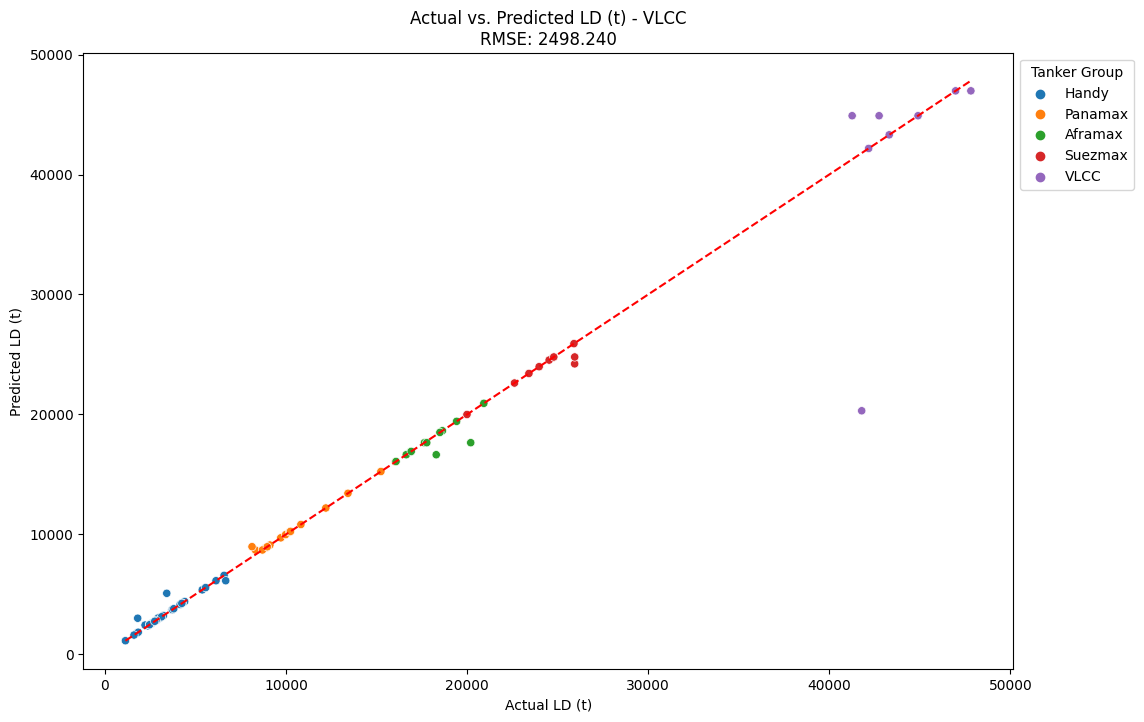

In [85]:
# Plot all points and their predicted values
import matplotlib.pyplot as plt
import seaborn as sns
# Plot separate panels for each 'Tanker Group'
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LD (t)', y='predicted_LD', data=ship_data, hue='Tanker Group')
plt.plot([ship_data['LD (t)'].min(), ship_data['LD (t)'].max()],
         [ship_data['LD (t)'].min(), ship_data['LD (t)'].max()],
         color='red', linestyle='--')
# plt.title('Actual vs. Predicted LD (t) - Separate Panels for Tanker Groups')
plt.title(f'Actual vs. Predicted LD (t) - {group}\nRMSE: {rmse:.3f}')
plt.xlabel('Actual LD (t)')
plt.ylabel('Predicted LD (t)')
plt.legend(title='Tanker Group', bbox_to_anchor=(1, 1))
plt.show()

## Plot Actual vs. Predicted LD (t), calculated over separate shyp types

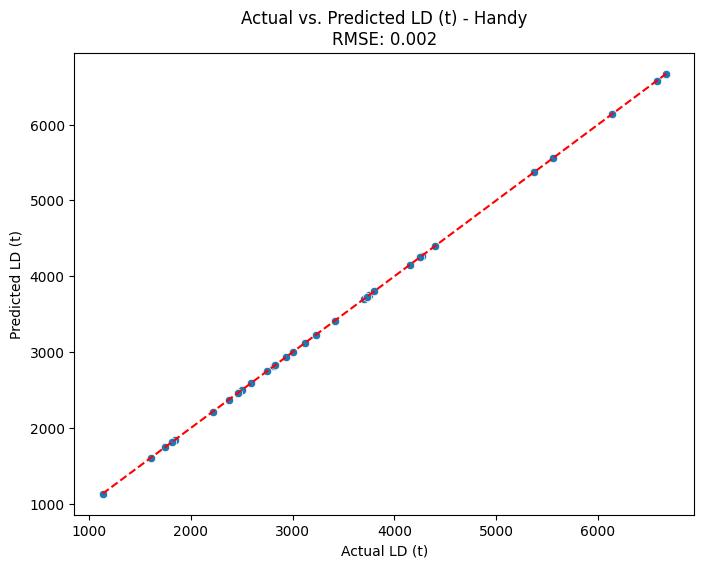

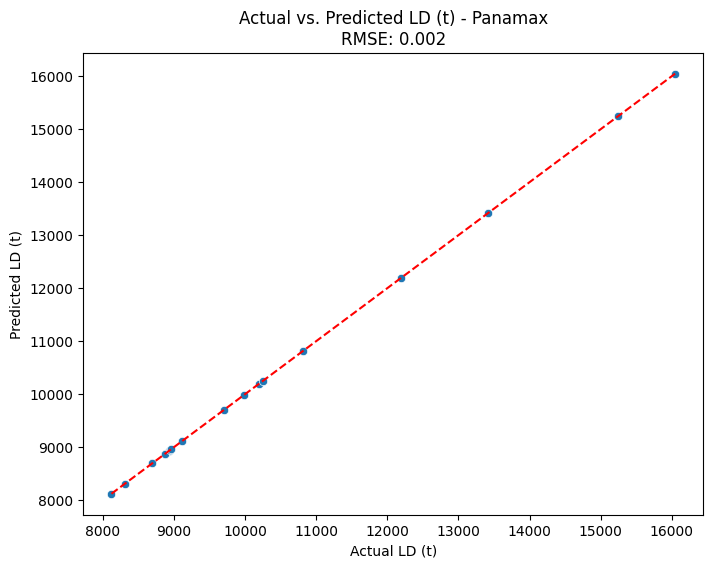

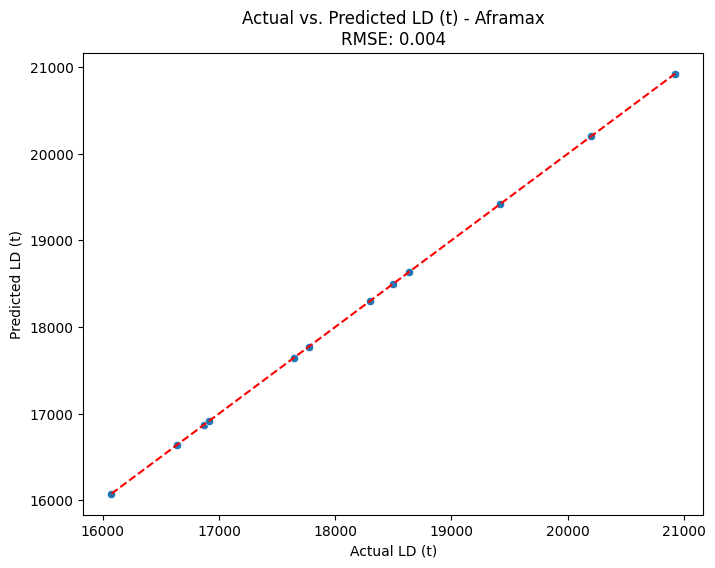

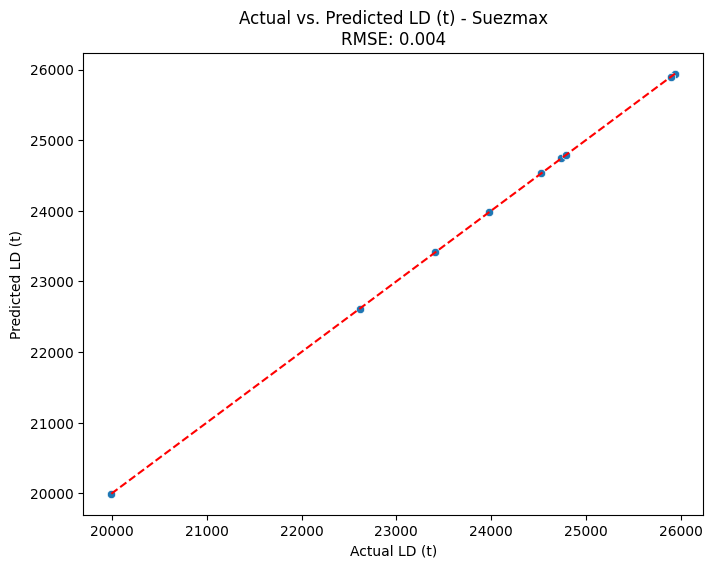

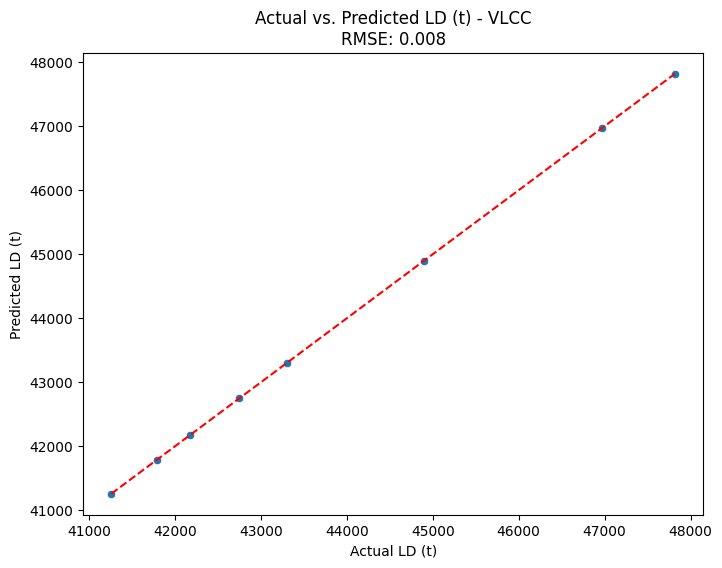

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
# Assuming 'ship_data' is your DataFrame

# List to store individual models
models_dict = {}

# Loop through unique 'Tanker Group' values
for group in ship_data['Tanker Group'].unique():
    # Filter the data for the current group
    subgroup_data = ship_data[ship_data['Tanker Group'] == group].copy()

    # Prepare the data
    X = subgroup_data[['LOA (m)', 'B (m)']].values
    y = subgroup_data['LD (t)'].values

    # Train the XGBoost model
    xgb_model = xgb.train(params=params,
                          dtrain=xgb.DMatrix(data=X, label=y),
                          num_boost_round=200,
                          verbose_eval=True)

    # Store the model in the dictionary
    models_dict[group] = xgb_model

    # Add predicted values to the subgroup_data DataFrame
    subgroup_data[f'predicted_LD_{group}'] = xgb_model.predict(xgb.DMatrix(data=X))

    # Add predicted values to the ship_data DataFrame
    ship_data.loc[ship_data['Tanker Group'] == group, f'predicted_LD_{group}'] = xgb_model.predict(xgb.DMatrix(data=X))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(subgroup_data['LD (t)'], subgroup_data[f'predicted_LD_{group}']))

    # Plot the points and their predicted values for the current group
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='LD (t)', y=f'predicted_LD_{group}', data=subgroup_data)
    plt.plot([subgroup_data['LD (t)'].min(), subgroup_data['LD (t)'].max()],
             [subgroup_data['LD (t)'].min(), subgroup_data['LD (t)'].max()],
             color='red', linestyle='--')
    # Display RMSE in the plot title
    plt.title(f'Actual vs. Predicted LD (t) - {group}\nRMSE: {rmse:.3f}')
    # plt.title(f'Actual vs. Predicted LD (t) - {group}')
    plt.xlabel('Actual LD (t)')
    plt.ylabel('Predicted LD (t)')
    plt.show()

# Access the models for each 'Tanker Group' as needed from models_dict


In [87]:
# Assuming 'models_dict' is your dictionary of models
variable_names = [name for name in globals() if name.startswith('models_dict')]
# Print the variable names
variable_names
# Display all names in models_dict
for group_name in models_dict.keys():
    print(group_name)

Handy
Panamax
Aframax
Suezmax
VLCC


## Calculate the models for each ship type

In [88]:
# Assuming 'ship_data' is your DataFrame

# List to store individual models
models_dict = {}

# Prepare the data:
X_all = ship_data[['LOA (m)', 'B (m)']].values
y_all = ship_data['LD (t)'].values

# Train the XGBoost model for all data
params = {
    'objective': 'reg:squarederror',  # for regression
    'eval_metric': 'rmse'  # root mean squared error
}
xgb_model_all = xgb.train(params=params,
                          dtrain=xgb.DMatrix(data=X_all, label=y_all),
                          num_boost_round=200,
                          verbose_eval=True)

# Save the xgb_model_all as a JSON file
xgb_model_all.save_model('xgb_model_all.json')

# Data frame to store model parameters
import pandas as pd

model_params_df = pd.DataFrame(columns=['Group', 'Max_Depth', 'Learning_Rate', 'Number_Of_Rounds', 'Model_File'])

# Loop through unique 'Tanker Group' values
for group in ship_data['Tanker Group'].unique():
    # Filter the data for the current group
    subgroup_data = ship_data[ship_data['Tanker Group'] == group].copy()

    # Prepare the data
    X = subgroup_data[['LOA (m)', 'B (m)']].values
    y = subgroup_data['LD (t)'].values

    # Train the XGBoost model
    xgb_model = xgb.train(params=params,
                          dtrain=xgb.DMatrix(data=X, label=y),
                          num_boost_round=200,
                          verbose_eval=True)

    # Store the model in the dictionary
    models_dict[group] = xgb_model

    # Save the model to a JSON file
    model_file_path = f"xgb_model_{group}.json"
    xgb_model.save_model(model_file_path)

import os

# Get the current directory
current_directory = os.getcwd()

# List all files in the current directory
files = os.listdir(current_directory)

# Filter files starting with "xgb_model_"
xgb_model_files = [file for file in files if file.startswith("xgb_model_")]

# Display the file names
xgb_model_files


['xgb_model_Handy.json',
 'xgb_model_Suezmax.model',
 'xgb_model_Panamax.model',
 'xgb_model_VLCC.json',
 'xgb_model_Aframax.model',
 'xgb_model_Handy.model',
 'xgb_model_all.json',
 'xgb_model_Panamax.json',
 'xgb_model_all.model',
 'xgb_model_Suezmax.json',
 'xgb_model_Aframax.json',
 'xgb_model_VLCC.model']

# Predicting LD

In [89]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown widget for selecting 'Tanker Group'
group_dropdown = widgets.Dropdown(
    options=['All ships'] + list(ship_data['Tanker Group'].unique()),
    value='All ships',
    description='Tanker Group:'
)

# Numeric input widget for LOA (m)
loa_input = widgets.FloatText(
    value=0.0,
    description='LOA (m):'
)

# Numeric input widget for B (m)
b_input = widgets.FloatText(
    value=0.0,
    description='B (m):'
)

# Button widget for calculation
calculate_button = widgets.Button(
    description='Calculate LD',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
)

# Output widget for displaying the result
output = widgets.Output()

# Function to handle button click event
def calculate_ld(button_click):
    with output:
        output.clear_output()

        selected_group = group_dropdown.value
        loa_value = loa_input.value
        b_value = b_input.value

        # Determine the model file based on the selected group
        if selected_group == 'All ships':
            model_file = 'xgb_model_all.json'
        else:
            model_file = f'xgb_model_{selected_group}.json'

        # Load the selected XGBoost model
        xgb_model = xgb.Booster(model_file=model_file)

        # Prepare the input data
        input_data = pd.DataFrame({'LOA (m)': [loa_value], 'B (m)': [b_value]})

        # Make the prediction
        ld_prediction = xgb_model.predict(xgb.DMatrix(input_data))

        # Round the prediction to 0 decimals
        ld_prediction_rounded = round(ld_prediction[0])
        # Display the rounded result
        print(f'\nPredicted LD value: {ld_prediction_rounded} (t)')

# Attach the event handler to the button click
calculate_button.on_click(calculate_ld)

# # Display the widgets
# display(group_dropdown, loa_input, b_input, calculate_button, output)


# Predict the LD of your ship
Select a Ship type from the widget Tanker Group (when your Ship type is not available in the drop down widget, select the first item "All ships"

In [90]:
# Display the widgets
display(group_dropdown, loa_input, b_input, calculate_button, output)

Dropdown(description='Tanker Group:', options=('All ships', 'Handy', 'Panamax', 'Aframax', 'Suezmax', 'VLCC'),…

FloatText(value=0.0, description='LOA (m):')

FloatText(value=0.0, description='B (m):')

Button(button_style='success', description='Calculate LD', style=ButtonStyle())

Output()

In [97]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Dropdown widget for selecting 'Tanker Group'
group_dropdown = widgets.Dropdown(
    options=['All ships'] + list(ship_data['Tanker Group'].unique()),
    value='All ships',
    description='Tanker Group:'
)

# Create lists to store input widgets and output labels for each ship
ship_widgets = []

# Create input widgets and output labels for each ship
for i in range(10):
    loa_input = widgets.FloatText(
        value=0.0,
        description=f'Ship {i + 1} LOA (m):'
    )
    b_input = widgets.FloatText(
        value=0.0,
        description=f'Ship {i + 1} B (m):'
    )
    output_label = widgets.Label(value=f'')#LD prediction: ----')

    ship_widgets.append([loa_input, b_input, output_label])

# Button widget for calculation
calculate_button = widgets.Button(
    description='Calculate LD',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
)

# Output widget for displaying the overall result
overall_output = widgets.Output()

# Function to handle button click event
def calculate_ld(button_click):
    with overall_output:
        overall_output.clear_output()
        print('\nOverall LD predictions:')

        selected_group = group_dropdown.value

        for i, widgets_list in enumerate(ship_widgets):
            loa_value = widgets_list[0].value
            b_value = widgets_list[1].value

            # Determine the model file based on the selected group
            if selected_group == 'All ships':
                model_file = 'xgb_model_all.json'
            else:
                model_file = f'xgb_model_{selected_group}.json'

            # Load the selected XGBoost model
            xgb_model = xgb.Booster(model_file=model_file)

            # Prepare the input data
            input_data = pd.DataFrame({'LOA (m)': [loa_value], 'B (m)': [b_value]})

            # Make the prediction
            ld_prediction = xgb_model.predict(xgb.DMatrix(input_data))

            # Round the prediction to 0 decimals
            ld_prediction_rounded = round(ld_prediction[0])

            # Display the rounded result for each ship in one line
            result_line = f'Ship {i + 1}: LOA={loa_value}, B={b_value}, LD prediction={ld_prediction_rounded} (t)'
            print(result_line)

# Attach the event handler to the button click
calculate_button.on_click(calculate_ld)

# Display the widgets
display(group_dropdown, calculate_button, overall_output)

# Display ship widgets in one line per ship
for widgets_list in ship_widgets:
    display(widgets.HBox(widgets_list))


Dropdown(description='Tanker Group:', options=('All ships', 'Handy', 'Panamax', 'Aframax', 'Suezmax', 'VLCC'),…

Button(button_style='success', description='Calculate LD', style=ButtonStyle())

Output()